### 임베딩 분석 및 시각화


In [ ]:
# 05_embedding_analysis.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
FRAMEWORK = 'torch' 

if FRAMEWORK == 'tf':
    embeddings = np.load('../embeddings/tf_embeddings.npy')
    metadata = pd.read_csv('../embeddings/tf_metadata.csv')
    print("TensorFlow 임베딩 로드")
else:
    embeddings = np.load('../embeddings/torch_embeddings.npy')
    metadata = pd.read_csv('../embeddings/torch_metadata.csv')
    print("PyTorch 임베딩 로드")

print(f"임베딩 형태: {embeddings.shape}")
print(f"메타데이터: {len(metadata)}개")
print(f"\n데이터 컬럼: {metadata.columns.tolist()}")

PyTorch 임베딩 로드
임베딩 형태: (861, 2048)
메타데이터: 861개

데이터 컬럼: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image_path']


### 기본 통계 분석

In [4]:
print(f"임베딩 통계:")
print(f"   평균: {np.mean(embeddings):.6f}")
print(f"   표준편차: {np.std(embeddings):.6f}")
print(f"   최솟값: {np.min(embeddings):.6f}")
print(f"   최댓값: {np.max(embeddings):.6f}")

if 'masterCategory' in metadata.columns:
    print(f"\n카테고리 분포:")
    category_counts = metadata['masterCategory'].value_counts()
    for cat, count in category_counts.items():
        print(f"   {cat}: {count}개")

임베딩 통계:
   평균: 0.375098
   표준편차: 0.409921
   최솟값: 0.000000
   최댓값: 7.188450

카테고리 분포:
   Apparel: 510개
   Accessories: 177개
   Footwear: 173개
   Free Items: 1개


### 차원 축소 (PCA)

PCA 50차원으로 설명되는 분산: 85.63%


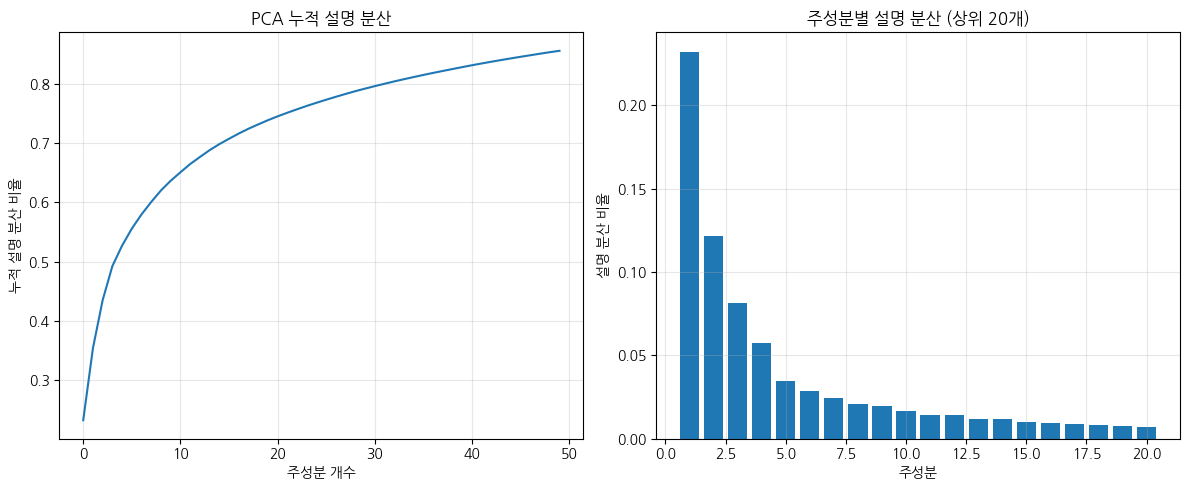

In [5]:
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

explained_var = np.sum(pca.explained_variance_ratio_[:50])
print(f"PCA 50차원으로 설명되는 분산: {explained_var*100:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_[:50]))
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산 비율')
plt.title('PCA 누적 설명 분산')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca.explained_variance_ratio_[:20])
plt.xlabel('주성분')
plt.ylabel('설명 분산 비율')
plt.title('주성분별 설명 분산 (상위 20개)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### t-SNE 시각화

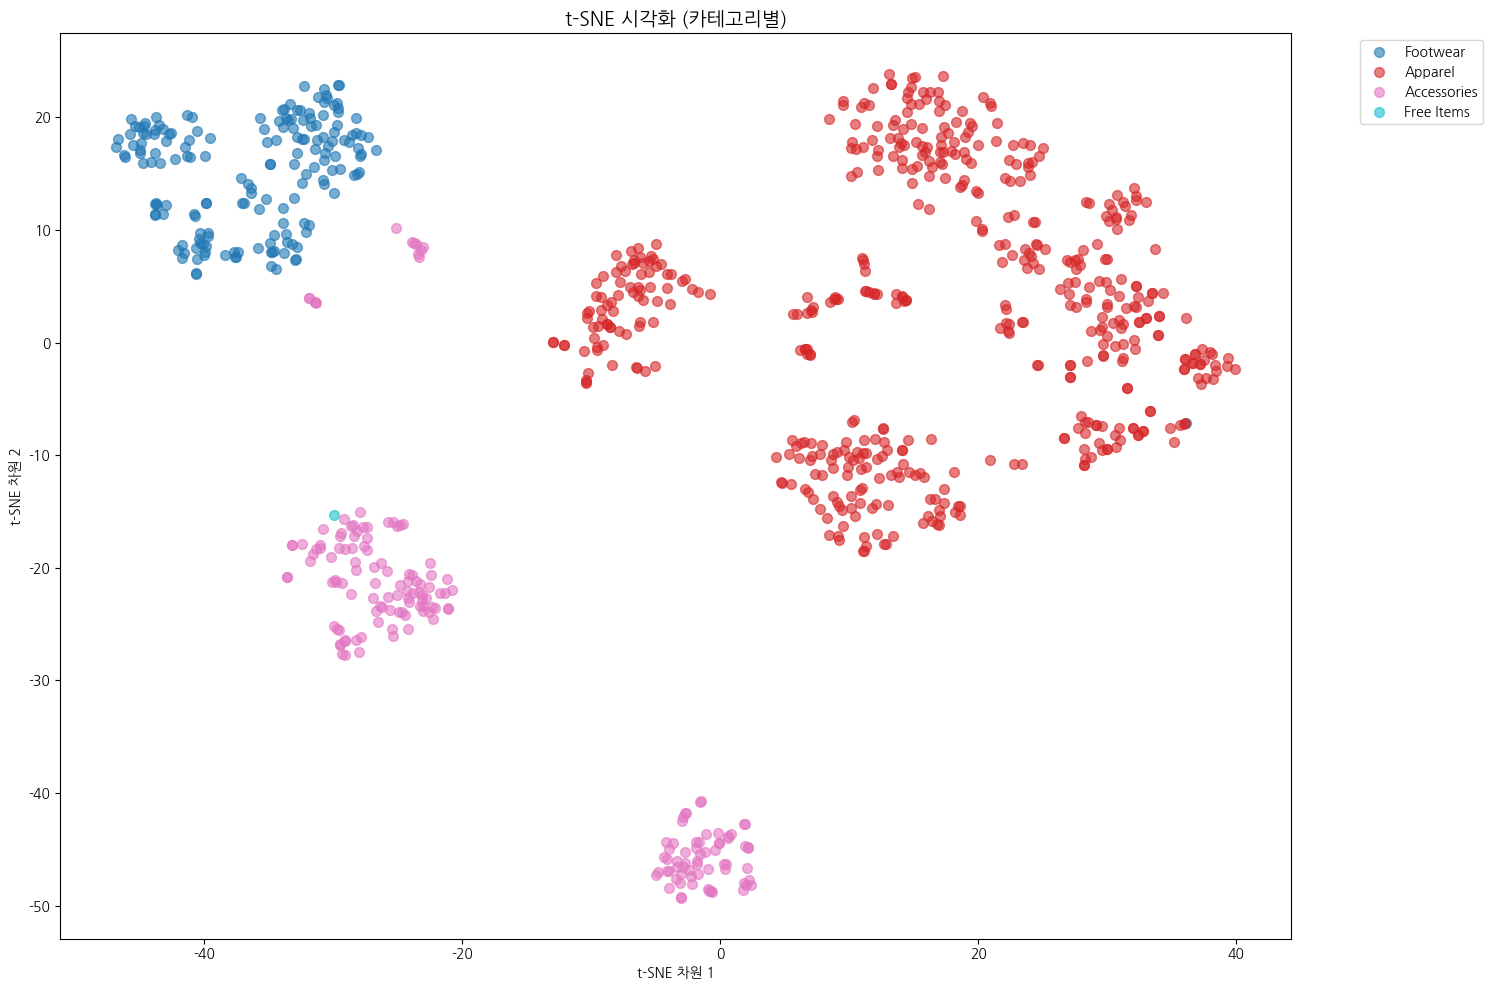

In [8]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_jobs=1)
embeddings_2d = tsne.fit_transform(embeddings_pca)
plt.figure(figsize=(15, 10))

if 'masterCategory' in metadata.columns:
    categories = metadata['masterCategory'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
    
    for i, category in enumerate(categories):
        mask = metadata['masterCategory'] == category
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[i]],
            label=category,
            alpha=0.6,
            s=50
        )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('t-SNE 시각화 (카테고리별)', fontsize=14)
else:
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50)
    plt.title('t-SNE 시각화', fontsize=14)

plt.xlabel('t-SNE 차원 1')
plt.ylabel('t-SNE 차원 2')
plt.tight_layout()
plt.show()

### 카테고리별 유사도 분석

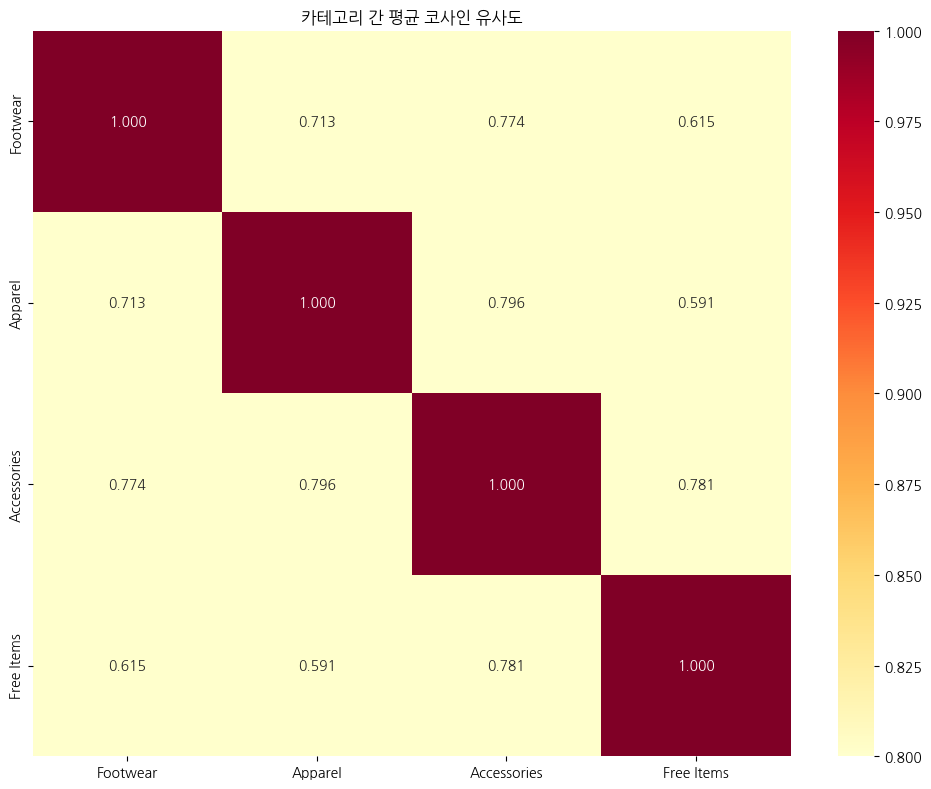

In [9]:
if 'masterCategory' in metadata.columns:
    categories = metadata['masterCategory'].unique()
    
    category_means = {}
    for cat in categories:
        mask = metadata['masterCategory'] == cat
        cat_embeddings = embeddings[mask]
        category_means[cat] = np.mean(cat_embeddings, axis=0)
    
    category_names = list(category_means.keys())
    n_categories = len(category_names)
    similarity_matrix = np.zeros((n_categories, n_categories))
    
    for i, cat1 in enumerate(category_names):
        for j, cat2 in enumerate(category_names):
            sim = cosine_similarity(
                category_means[cat1].reshape(1, -1),
                category_means[cat2].reshape(1, -1)
            )[0, 0]
            similarity_matrix[i, j] = sim
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt='.3f',
        xticklabels=category_names,
        yticklabels=category_names,
        cmap='YlOrRd',
        vmin=0.8,
        vmax=1.0
    )
    plt.title('카테고리 간 평균 코사인 유사도')
    plt.tight_layout()
    plt.show()

### 유사 상품 추천 시스템

In [10]:
def recommend_similar_items(item_idx, top_k=5):
    target_embedding = embeddings[item_idx].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, embeddings)[0]
    
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"\nBase Item:")
    print(f"   ID: {metadata.iloc[item_idx]['id']}")
    if 'productDisplayName' in metadata.columns:
        print(f"   Product Name: {metadata.iloc[item_idx]['productDisplayName']}")
    if 'masterCategory' in metadata.columns:
        print(f"   Category: {metadata.iloc[item_idx]['masterCategory']}")
    
    print(f"\nTop {top_k} Similar Items:")
    for rank, idx in enumerate(similar_indices, 1):
        sim_score = similarities[idx]
        print(f"\n{rank}. Similarity: {sim_score:.4f}")
        print(f"   ID: {metadata.iloc[idx]['id']}")
        if 'productDisplayName' in metadata.columns:
            print(f"   Product Name: {metadata.iloc[idx]['productDisplayName']}")
        if 'masterCategory' in metadata.columns:
            print(f"   Category: {metadata.iloc[idx]['masterCategory']}")
    
    return similar_indices, similarities[similar_indices]

test_indices = [0, 10, 50]
for idx in test_indices:
    similar_items, scores = recommend_similar_items(idx, top_k=5)



Base Item:
   ID: 10268
   Product Name: Clarks Men Hang Work Leather Black Formal Shoes
   Category: Footwear

Top 5 Similar Items:

1. Similarity: 0.9622
   ID: 10297
   Product Name: Clarks Men Black Leather Loafers
   Category: Footwear

2. Similarity: 0.9493
   ID: 10281
   Product Name: Clarks Men Hang Spring Leather Black Formal Shoes
   Category: Footwear

3. Similarity: 0.9492
   ID: 10265
   Product Name: Clarks Men Goto Eat Tobacco Leather Brown Formal Shoes
   Category: Footwear

4. Similarity: 0.9486
   ID: 10301
   Product Name: Clarks Brown Leather Casual Shoes
   Category: Footwear

5. Similarity: 0.9472
   ID: 10286
   Product Name: Clarks Men Hang Tough Leather Black Formal Shoes
   Category: Footwear

Base Item:
   ID: 10406
   Product Name: United Colors of Benetton Women Solid Grey Dresses
   Category: Apparel

Top 5 Similar Items:

1. Similarity: 0.9389
   ID: 10429
   Product Name: United Colors of Benetton Women Solid Black Top
   Category: Apparel

2. Similari

### 유사도 분포 분석

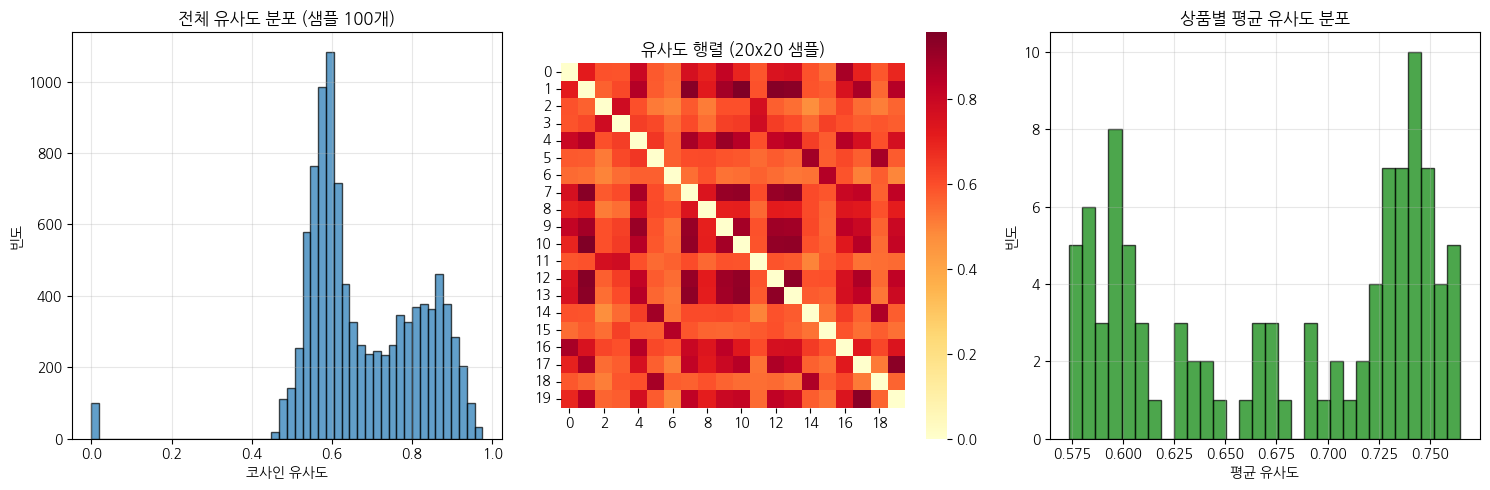


유사도 통계:
   평균: 0.6778
   표준편차: 0.1460
   최솟값: 0.4556
   최댓값: 0.9755


In [12]:
sample_size = min(100, len(embeddings))
sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)

sample_embeddings = embeddings[sample_indices]
similarity_matrix = cosine_similarity(sample_embeddings)

np.fill_diagonal(similarity_matrix, 0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(similarity_matrix.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('코사인 유사도')
plt.ylabel('빈도')
plt.title(f'전체 유사도 분포 (샘플 {sample_size}개)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
sns.heatmap(similarity_matrix[:20, :20], cmap='YlOrRd', square=True)
plt.title('유사도 행렬 (20x20 샘플)')

plt.subplot(1, 3, 3)
avg_similarities = np.mean(similarity_matrix, axis=1)
plt.hist(avg_similarities, bins=30, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('평균 유사도')
plt.ylabel('빈도')
plt.title('상품별 평균 유사도 분포')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n유사도 통계:")
print(f"   평균: {np.mean(similarity_matrix):.4f}")
print(f"   표준편차: {np.std(similarity_matrix):.4f}")
print(f"   최솟값: {np.min(similarity_matrix[similarity_matrix > 0]):.4f}")
print(f"   최댓값: {np.max(similarity_matrix):.4f}")


In [14]:
print(f"Results:")
print(f"   - 임베딩 차원: {embeddings.shape[1]}")
print(f"   - 총 상품 수: {len(embeddings)}")
if 'masterCategory' in metadata.columns:
    print(f"   - 카테고리 수: {len(metadata['masterCategory'].unique())}")
print(f"   - PCA 50차원 설명력: {explained_var*100:.2f}%")
print(f"   - 평균 상품 간 유사도: {np.mean(similarity_matrix):.4f}")

Results:
   - 임베딩 차원: 2048
   - 총 상품 수: 861
   - 카테고리 수: 4
   - PCA 50차원 설명력: 85.63%
   - 평균 상품 간 유사도: 0.6778
